In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
#!/bin/bash
!kaggle datasets download rm1000/brain-tumor-mri-scans

Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
brain-tumor-mri-scans.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
%ls

Brain.ipynb                                 docker-examples/
NVIDIA_Deep_Learning_Container_License.pdf  examples/
README.md                                   tutorials/
brain-tumor-mri-scans.zip


In [5]:
!unzip brain-tumor-mri-scans.zip

Archive:  brain-tumor-mri-scans.zip
  inflating: glioma/0000.jpg         
  inflating: glioma/0001.jpg         
  inflating: glioma/0002.jpg         
  inflating: glioma/0003.jpg         
  inflating: glioma/0004.jpg         
  inflating: glioma/0005.jpg         
  inflating: glioma/0006.jpg         
  inflating: glioma/0007.jpg         
  inflating: glioma/0008.jpg         
  inflating: glioma/0009.jpg         
  inflating: glioma/0010.jpg         
  inflating: glioma/0011.jpg         
  inflating: glioma/0012.jpg         
  inflating: glioma/0013.jpg         
  inflating: glioma/0014.jpg         
  inflating: glioma/0015.jpg         
  inflating: glioma/0016.jpg         
  inflating: glioma/0017.jpg         
  inflating: glioma/0018.jpg         
  inflating: glioma/0019.jpg         
  inflating: glioma/0020.jpg         
  inflating: glioma/0021.jpg         
  inflating: glioma/0022.jpg         
  inflating: glioma/0023.jpg         
  inflating: glioma/0024.jpg         
  inflating: g

In [6]:
!nvidia-smi

Thu Oct 10 11:47:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.6     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   28C    P0              59W / 400W |      0MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [7]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageOps, ImageEnhance
import random
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import copy
import time


In [8]:

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = ['glioma', 'healthy', 'meningioma', 'pituitary']

        # Gather image paths and labels
        for idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images.append(image_path)
                self.labels.append(idx)  # Assign an integer label to each class

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define manual data augmentation transforms using PIL
def manual_augmentations(image):
    # Resize to 224x224
    image = image.resize((224, 224))

    # Random horizontal flip
    if random.random() > 0.5:
        image = ImageOps.mirror(image)

    # Random rotation (-15 to +15 degrees)
    angle = random.uniform(-15, 15)
    image = image.rotate(angle)

    # Random brightness
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(random.uniform(0.8, 1.2))

    # Random contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(random.uniform(0.8, 1.2))

    # Convert to Tensor and Normalize
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform(image)


In [9]:

# Validation/test transforms (only resizing and normalizing)
def validation_augmentations(image):
    # Resize to 224x224
    image = image.resize((224, 224))

    # Convert to Tensor and Normalize
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform(image)

# Directory paths
data_dir = '.'

# Load dataset and apply transforms
full_dataset = CustomImageDataset(data_dir, transform=manual_augmentations)


In [10]:
%ls

Brain.ipynb                                 docker-examples/  meningioma/
NVIDIA_Deep_Learning_Container_License.pdf  examples/         pituitary/
README.md                                   glioma/           tutorials/
brain-tumor-mri-scans.zip                   healthy/


In [11]:
full_dataset

In [12]:

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


In [13]:
len(train_dataset)

4916

In [14]:
len(val_dataset)

1053

In [15]:
len(test_dataset)

1054

In [16]:
# Apply validation/test transforms
val_dataset.dataset.transform = validation_augmentations
test_dataset.dataset.transform = validation_augmentations


In [17]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# Function to unnormalize and plot images
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize if normalization was applied
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()


In [19]:
# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


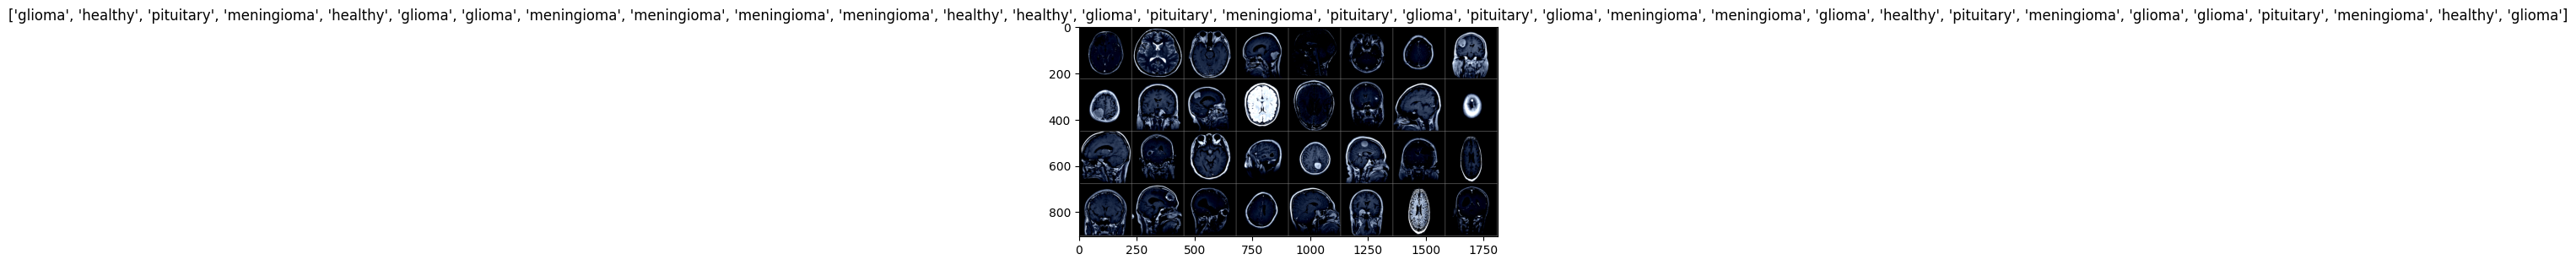

In [20]:
# Make a grid from the batch of images
out = torchvision.utils.make_grid(images)

# Display images with class names
class_names = ['glioma', 'healthy', 'meningioma', 'pituitary']
imshow(out, title=[class_names[label] for label in labels])

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [22]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) 
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train() 
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        scheduler.step(val_loss)
        
        print(f"Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}, Val Acc: {val_acc}")
        
        history['train_loss'].append(running_loss/len(train_loader))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history

def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(data_loader), 100 * correct / total


In [25]:
!nvidia-smi

Thu Oct 10 11:47:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.6     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   28C    P0              65W / 400W |    541MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [26]:
import time

num_epochs = 5
start_time = time.time()
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
end_time = time.time() 

total_time = end_time - start_time
print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')


Epoch 1/5
Train Loss: 0.41836062339799746, Val Loss: 0.38562135195190256, Val Acc: 87.17948717948718
Epoch 2/5
Train Loss: 0.27175583675890774, Val Loss: 0.24216727381854347, Val Acc: 90.97815764482431
Epoch 3/5
Train Loss: 0.19481293546253597, Val Loss: 0.6326722863948706, Val Acc: 74.4539411206078
Epoch 4/5
Train Loss: 0.16097313565407673, Val Loss: 1.112987458705902, Val Acc: 65.05223171889838
Epoch 5/5
Train Loss: 0.10777271239770359, Val Loss: 0.1600696003120957, Val Acc: 94.49192782526116
Training complete in 5m 27s
